## CREDIT RISK PREDICTION

**In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.**


It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:

    - Age (numeric)
    - Sex (text: male, female)
    - Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
    - Housing (text: own, rent, or free)
    - Saving accounts (text - little, moderate, quite rich, rich)
    - Checking account (numeric, in DM - Deutsch Mark)
    - Credit amount (numeric, in DM)
    - Duration (numeric, in month)
    - Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [414]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [415]:
df = pd.read_csv("german_credit_data.csv")

In [416]:
df.head(20)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car
5,5,35,male,1,free,NaN,NaN,9055,36,education
6,6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment
7,7,35,male,3,rent,little,moderate,6948,36,car
8,8,61,male,1,own,rich,NaN,3059,12,radio/TV
9,9,28,male,3,own,little,moderate,5234,30,car


In [417]:
#Dropping unnecessary columns
df.rename(columns = {'Unnamed: 0': 'ID'}, inplace = True)

## Data Wrangling

In [418]:
df.shape

(1000, 10)

In [419]:
#Checking missing values
df.isna().sum()

ID                    0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [420]:
job_cat = {0 : 'unskilled & non-resident', 
           1 : 'unskilled & resident', 
           2 : 'skilled', 
           3 : 'highly skilled'}
df['Job_cat'] = df['Job'].map(job_cat)

In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Job_cat           1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


### 1. EDA

In [422]:
df_dtypes = df.dtypes.reset_index()

In [423]:
numericals

,index,0
0,Unnamed: 0,int64
1,Age,int64
3,Job,int64
7,Credit amount,int64
8,Duration,int64
11,Savings,float64
12,Checking,float64


In [424]:
categories = pd.DataFrame(df_dtypes[df_dtypes[0] == 'object'])
numericals = pd.DataFrame(df_dtypes[df_dtypes[0] != 'object'])
numericals = numericals.loc[numericals['index'] != 'ID']

In [425]:
df.describe()

,ID,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


Age


<AxesSubplot:xlabel='Age', ylabel='Count'>

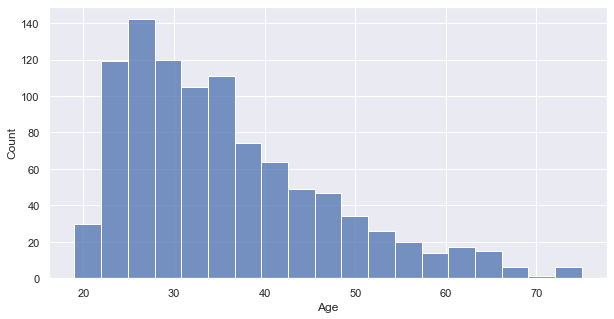

Job


<AxesSubplot:xlabel='Job', ylabel='Count'>

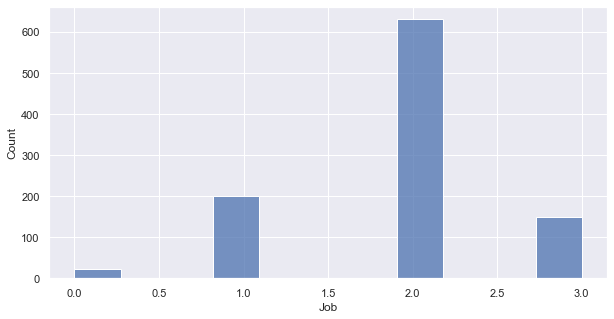

Credit amount


<AxesSubplot:xlabel='Credit amount', ylabel='Count'>

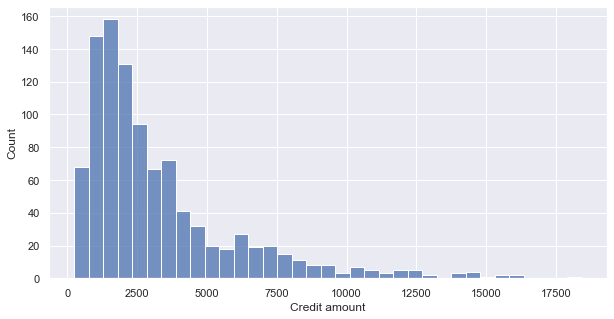

Duration


<AxesSubplot:xlabel='Duration', ylabel='Count'>

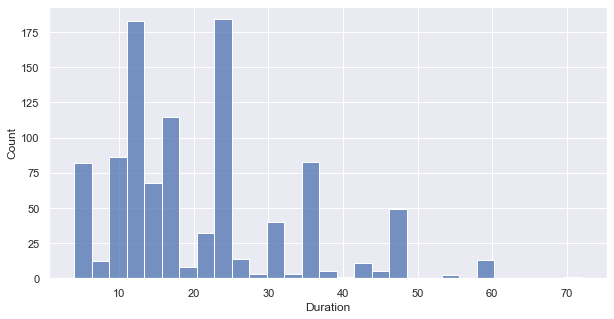

In [426]:
#Histograms of numericals
for i in df[numericals['index']]:
    print(i)
    plt.figure(figsize = (10,5))
    plt.xlabel(i)
    display(sns.histplot(data = df, x = i))
    plt.show()

Sex


<AxesSubplot:xlabel='Sex', ylabel='Count'>

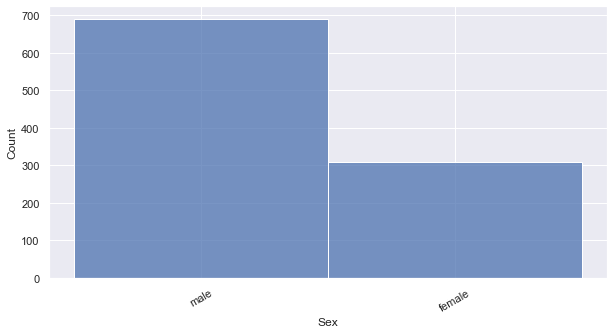

Housing


<AxesSubplot:xlabel='Housing', ylabel='Count'>

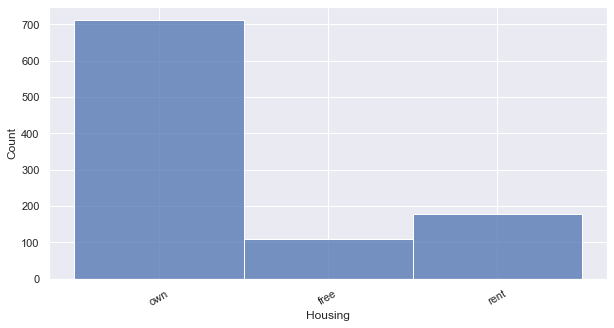

Saving accounts


<AxesSubplot:xlabel='Saving accounts', ylabel='Count'>

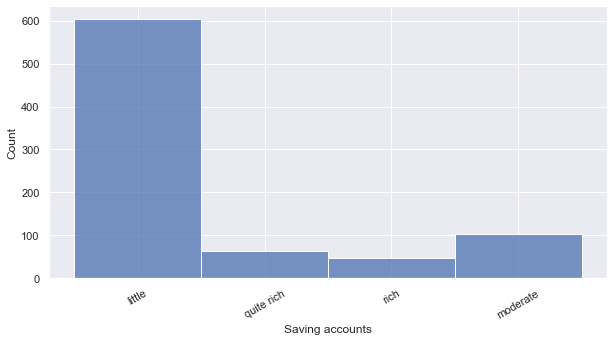

Checking account


<AxesSubplot:xlabel='Checking account', ylabel='Count'>

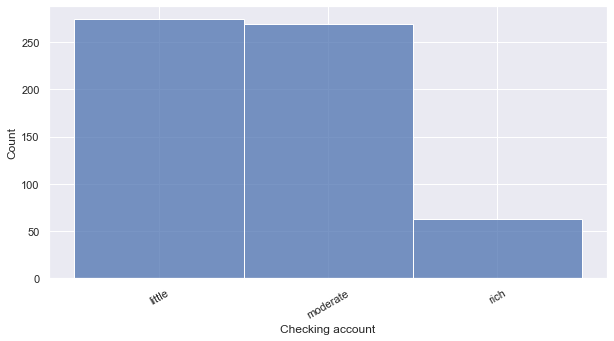

Purpose


<AxesSubplot:xlabel='Purpose', ylabel='Count'>

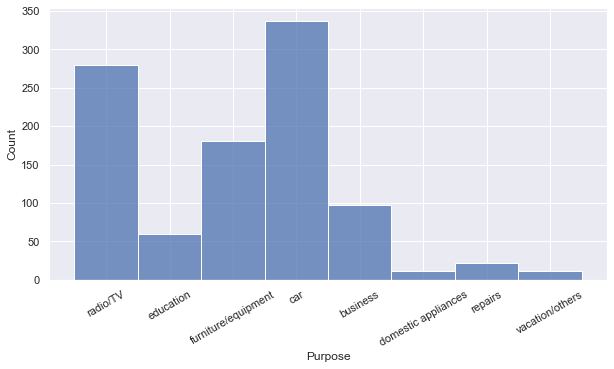

Job_cat


<AxesSubplot:xlabel='Job_cat', ylabel='Count'>

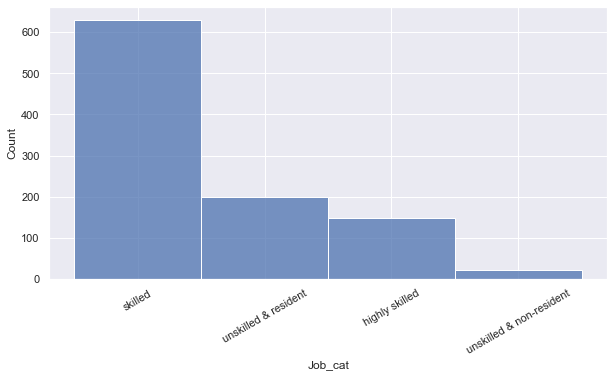

In [427]:
#Histograms of category variables
for i in df[categories['index']]:
    print(i)
    plt.figure(figsize = (10,5))
    plt.xlabel(i)
    plt.xticks(rotation = 30)
    display(sns.histplot(data = df, x = i))
    plt.show()

Plot for the variation of {} vs Credit Amount Checking account


<AxesSubplot:xlabel='Checking account', ylabel='Credit amount'>

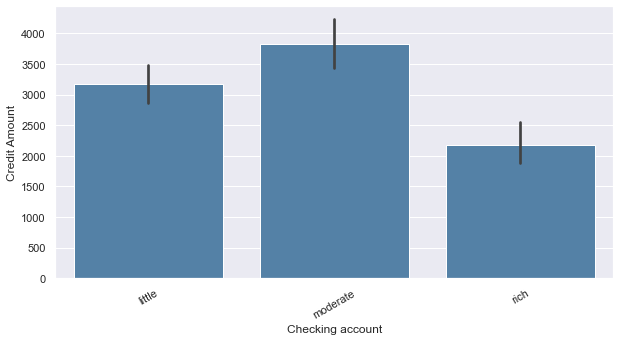

Plot for the variation of {} vs Credit Amount Saving accounts


<AxesSubplot:xlabel='Saving accounts', ylabel='Credit amount'>

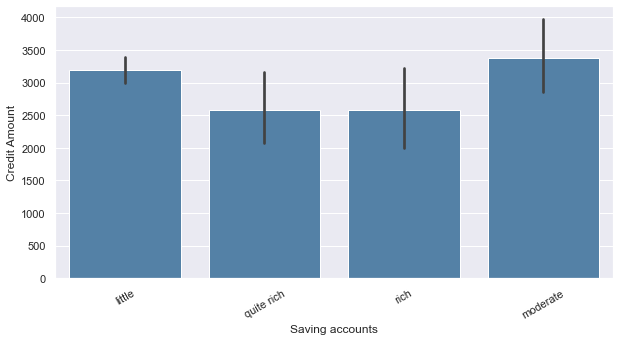

Plot for the variation of {} vs Credit Amount Housing


<AxesSubplot:xlabel='Housing', ylabel='Credit amount'>

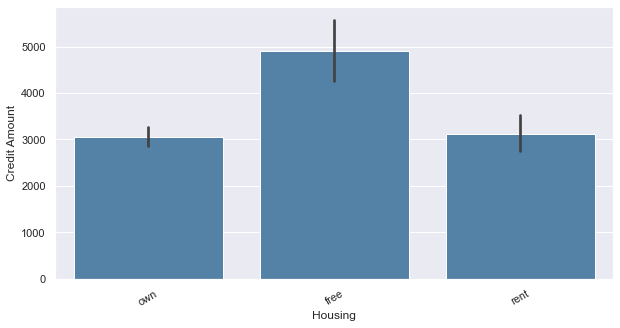

Plot for the variation of {} vs Credit Amount Purpose


<AxesSubplot:xlabel='Purpose', ylabel='Credit amount'>

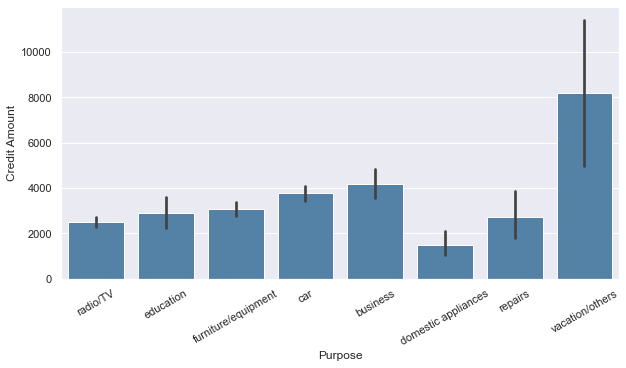

Plot for the variation of {} vs Credit Amount Job_cat


<AxesSubplot:xlabel='Job_cat', ylabel='Credit amount'>

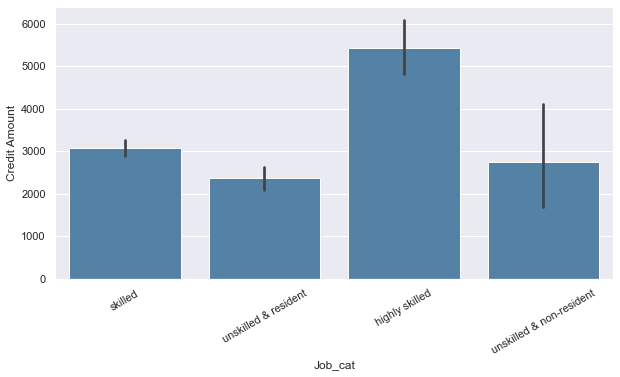

In [428]:
# With respect to credit amount
for i in ['Checking account','Saving accounts','Housing','Purpose','Job_cat' ]:
    print("Plot for the variation of {} vs Credit Amount",str(i))
    plt.figure(figsize = (10,5))
    display(sns.barplot(data = df, x = i, y = df['Credit amount'], color = 'steelblue'))
    plt.xlabel(i)
    plt.xticks(rotation = 30)
    plt.ylabel("Credit Amount")
    plt.show()

Plot for the variation of {} vs Duration Checking account


<AxesSubplot:xlabel='Checking account', ylabel='Duration'>

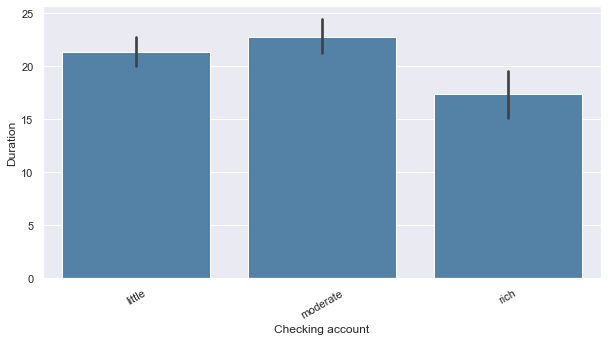

Plot for the variation of {} vs Duration Saving accounts


<AxesSubplot:xlabel='Saving accounts', ylabel='Duration'>

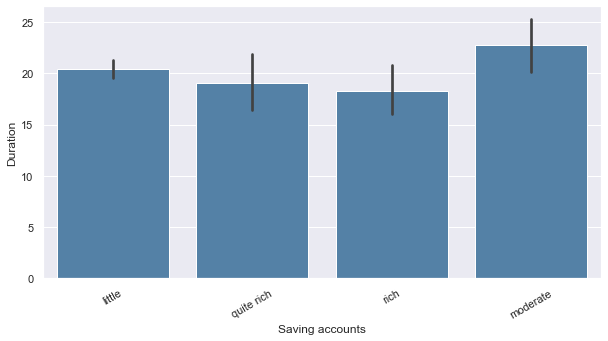

Plot for the variation of {} vs Duration Housing


<AxesSubplot:xlabel='Housing', ylabel='Duration'>

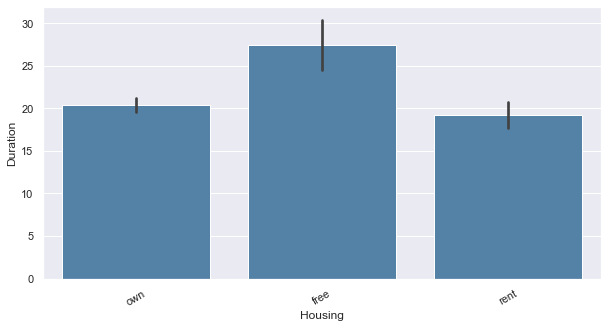

Plot for the variation of {} vs Duration Purpose


<AxesSubplot:xlabel='Purpose', ylabel='Duration'>

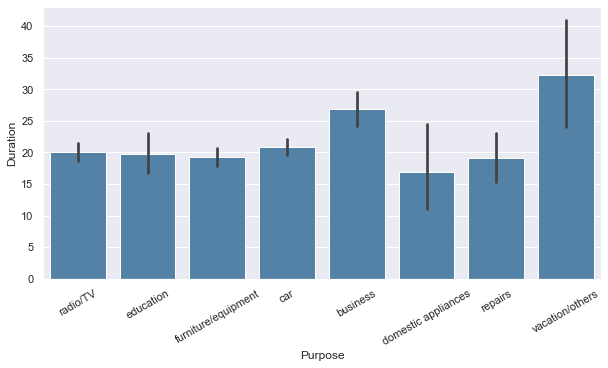

Plot for the variation of {} vs Duration Job_cat


<AxesSubplot:xlabel='Job_cat', ylabel='Duration'>

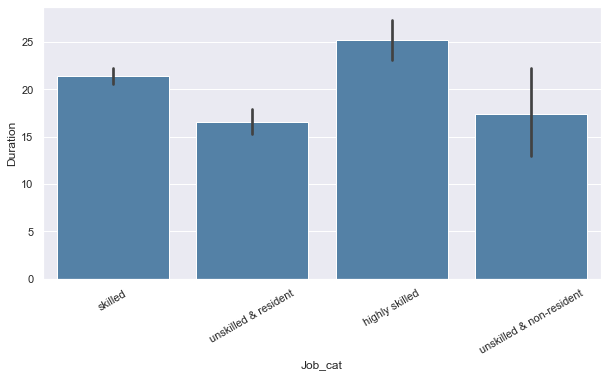

In [429]:
# With respect to duration
for i in ['Checking account','Saving accounts','Housing','Purpose','Job_cat' ]:
    print("Plot for the variation of {} vs Duration",str(i))
    plt.figure(figsize = (10,5))
    display(sns.barplot(data = df, x = i, y = df['Duration'], color = 'steelblue'))
    plt.xlabel(i)
    plt.xticks(rotation = 30)
    plt.ylabel("Duration")
    plt.show()

Histogram of  Age with hue Sex


<AxesSubplot:xlabel='Age', ylabel='Count'>

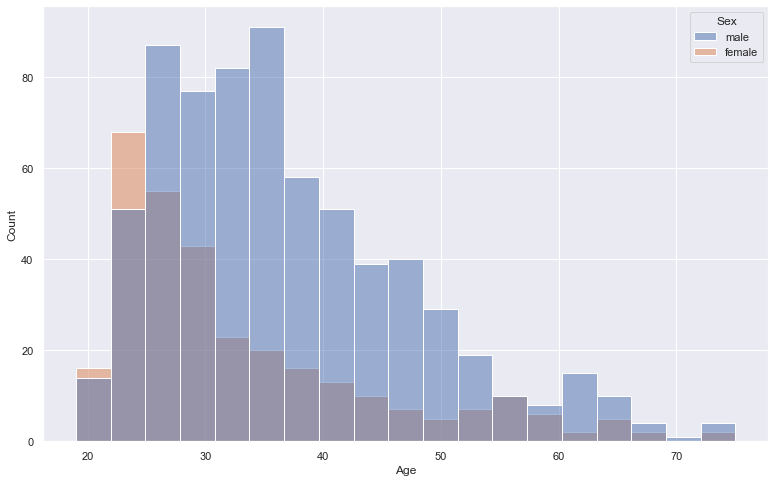

Histogram of  Age with hue Housing


<AxesSubplot:xlabel='Age', ylabel='Count'>

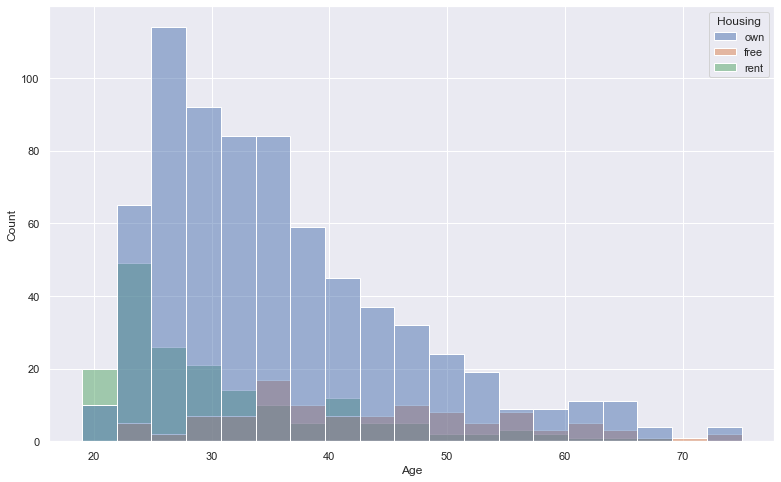

Histogram of  Age with hue Saving accounts


<AxesSubplot:xlabel='Age', ylabel='Count'>

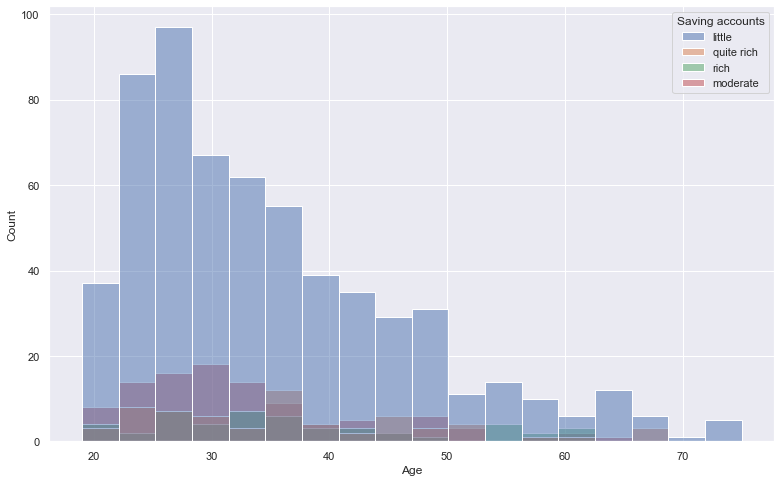

Histogram of  Age with hue Checking account


<AxesSubplot:xlabel='Age', ylabel='Count'>

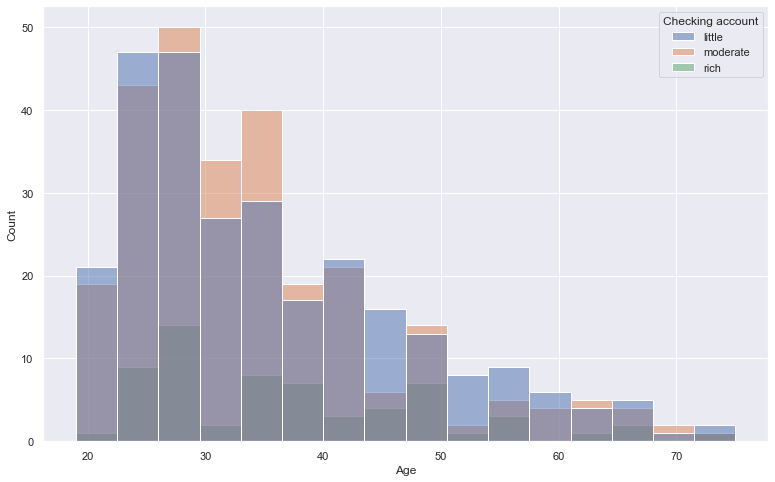

Histogram of  Age with hue Purpose


<AxesSubplot:xlabel='Age', ylabel='Count'>

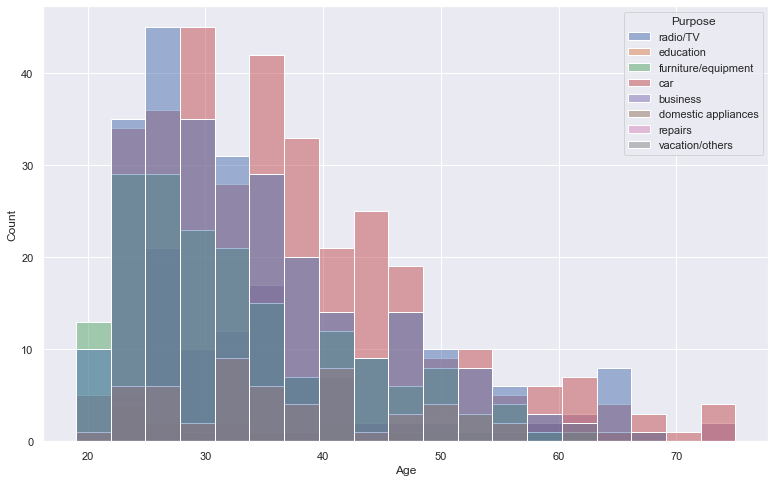

Histogram of  Age with hue Job_cat


<AxesSubplot:xlabel='Age', ylabel='Count'>

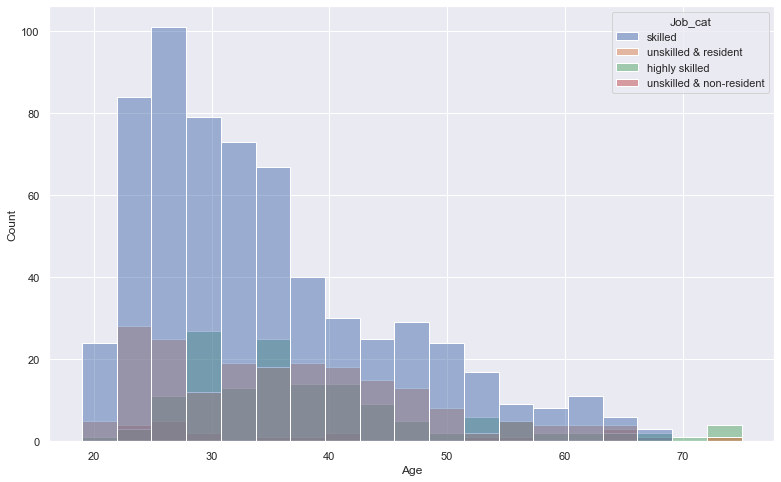

Histogram of  Job with hue Sex


<AxesSubplot:xlabel='Job', ylabel='Count'>

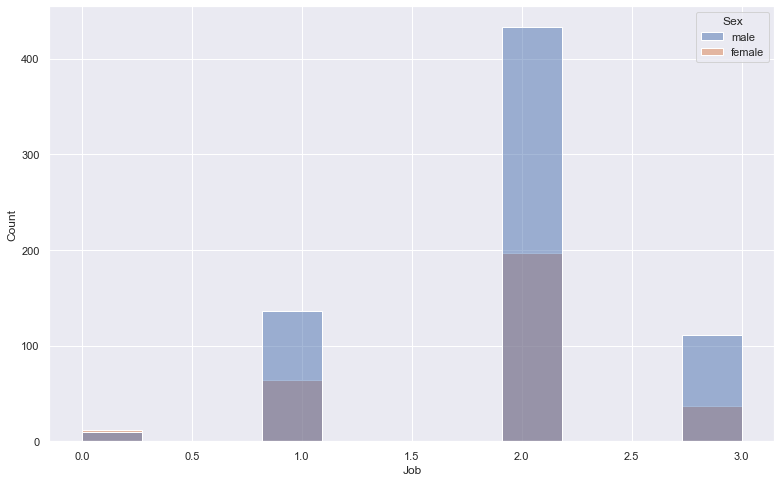

Histogram of  Job with hue Housing


<AxesSubplot:xlabel='Job', ylabel='Count'>

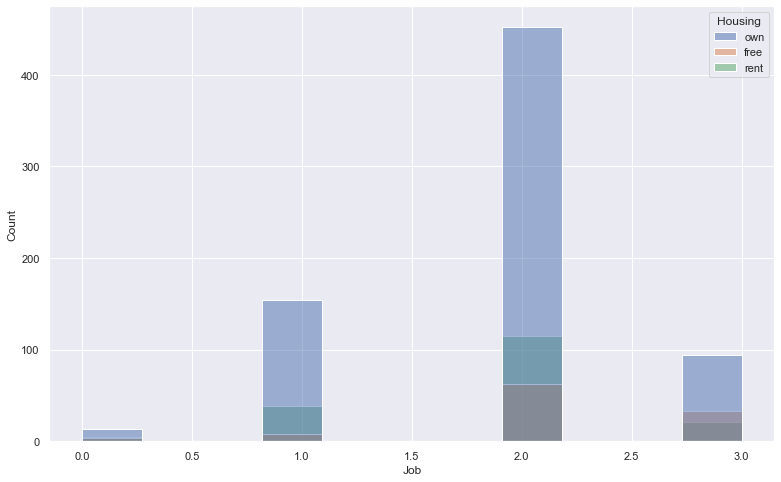

Histogram of  Job with hue Saving accounts


<AxesSubplot:xlabel='Job', ylabel='Count'>

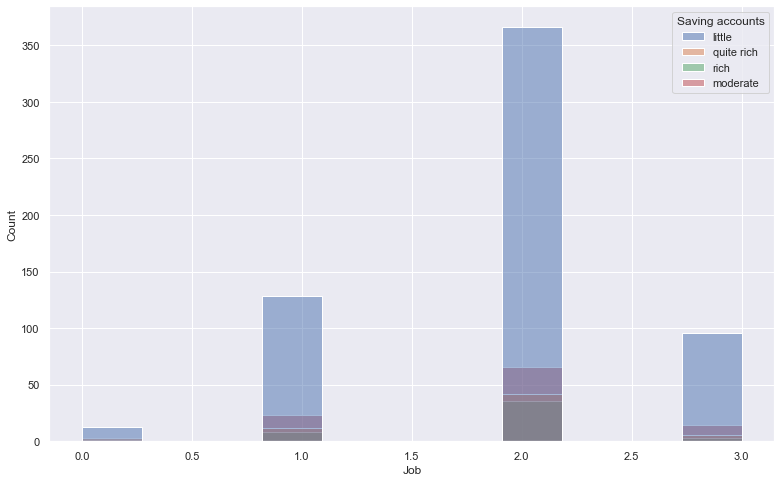

Histogram of  Job with hue Checking account


<AxesSubplot:xlabel='Job', ylabel='Count'>

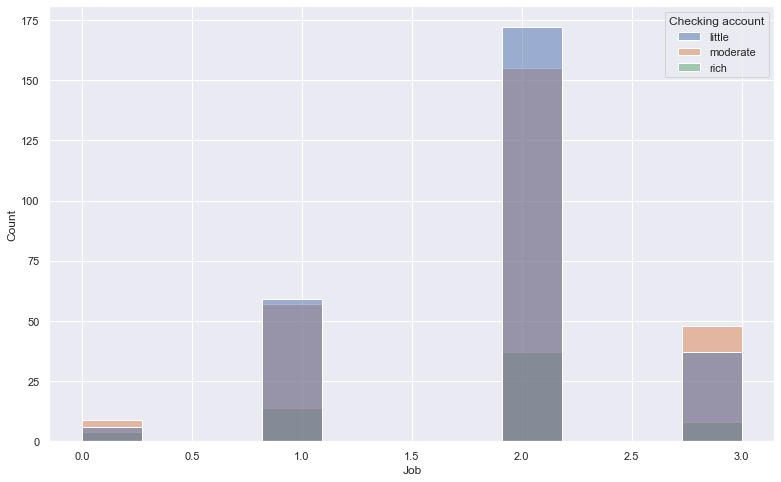

Histogram of  Job with hue Purpose


<AxesSubplot:xlabel='Job', ylabel='Count'>

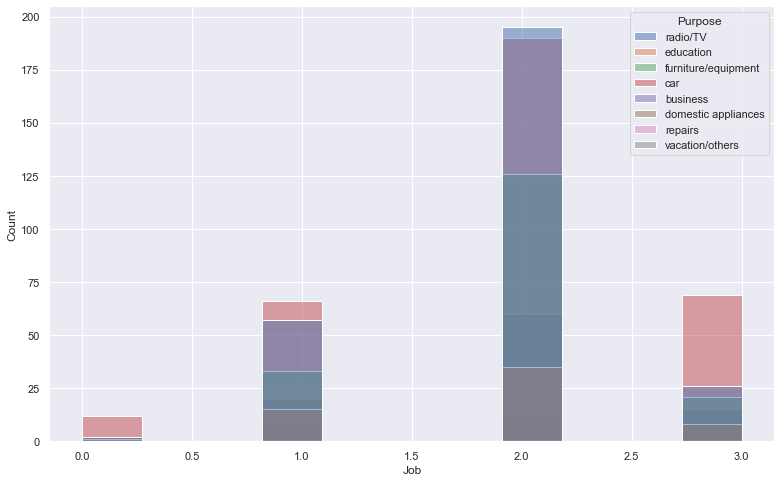

Histogram of  Job with hue Job_cat


<AxesSubplot:xlabel='Job', ylabel='Count'>

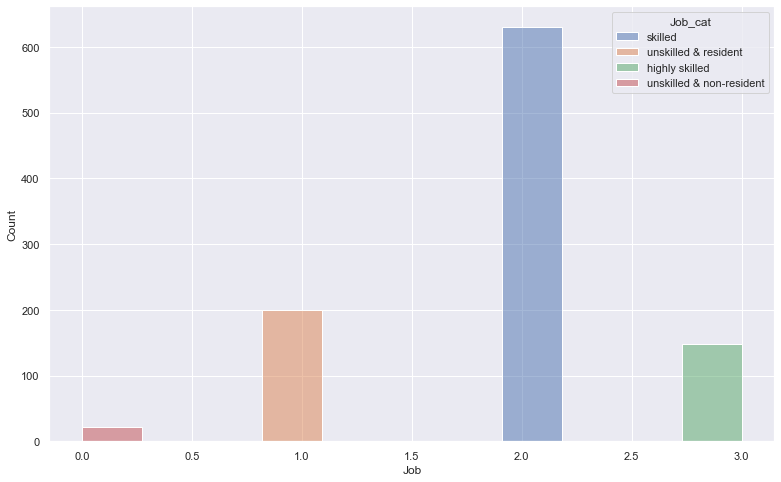

Histogram of  Credit amount with hue Sex


<AxesSubplot:xlabel='Credit amount', ylabel='Count'>

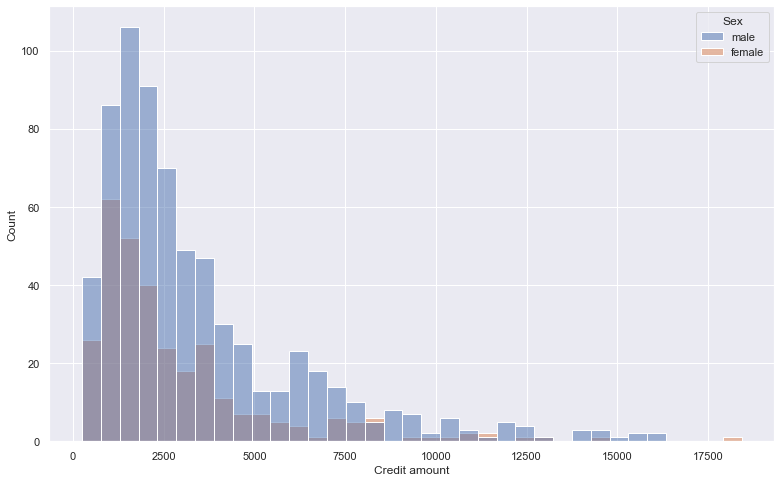

Histogram of  Credit amount with hue Housing


<AxesSubplot:xlabel='Credit amount', ylabel='Count'>

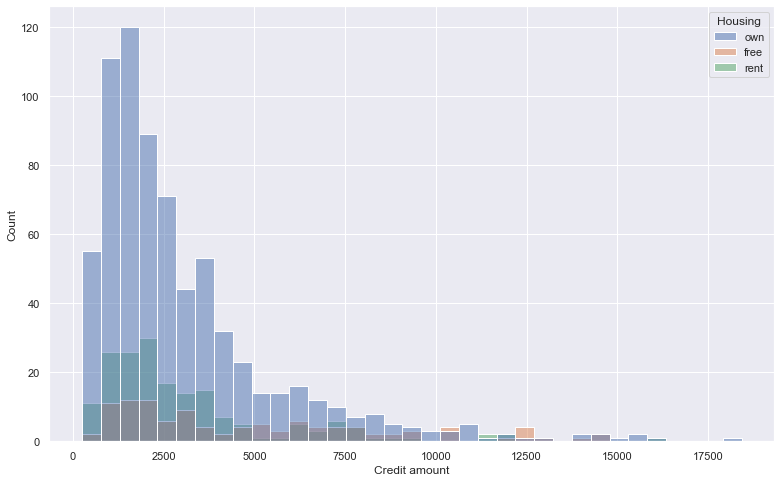

Histogram of  Credit amount with hue Saving accounts


<AxesSubplot:xlabel='Credit amount', ylabel='Count'>

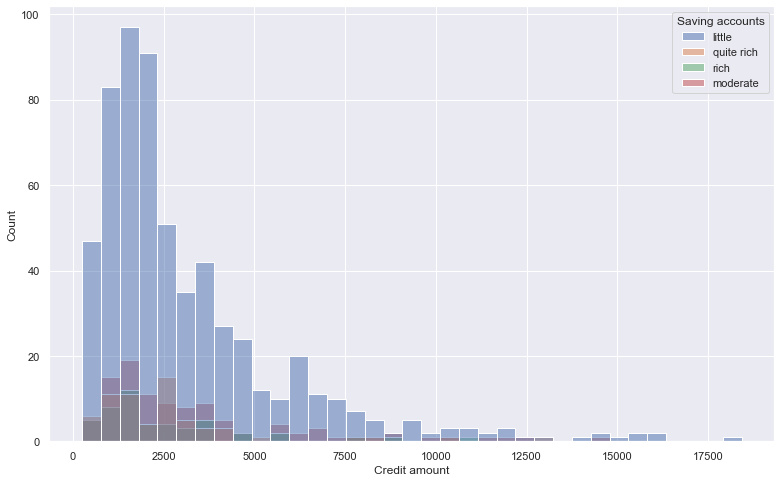

Histogram of  Credit amount with hue Checking account


<AxesSubplot:xlabel='Credit amount', ylabel='Count'>

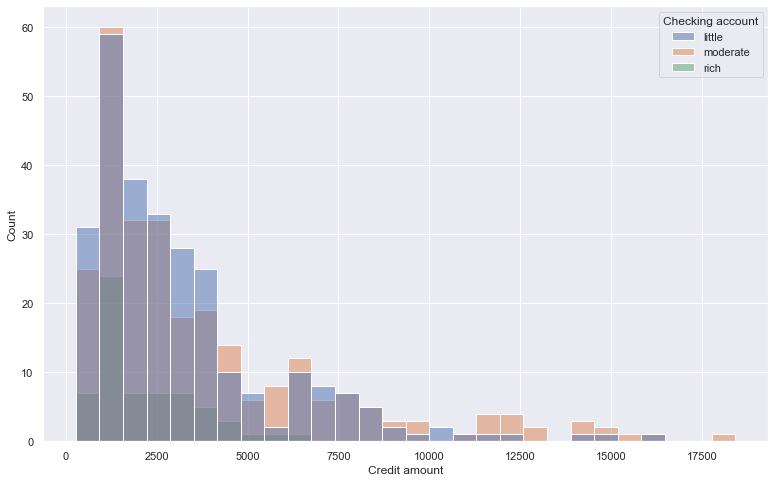

Histogram of  Credit amount with hue Purpose


<AxesSubplot:xlabel='Credit amount', ylabel='Count'>

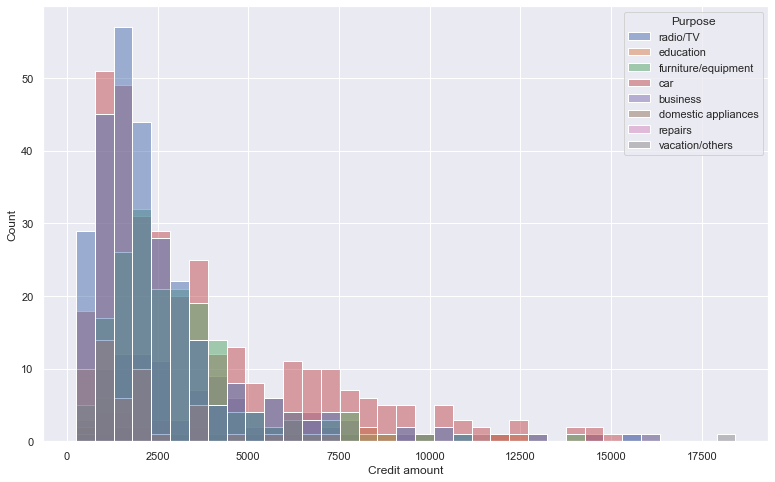

Histogram of  Credit amount with hue Job_cat


<AxesSubplot:xlabel='Credit amount', ylabel='Count'>

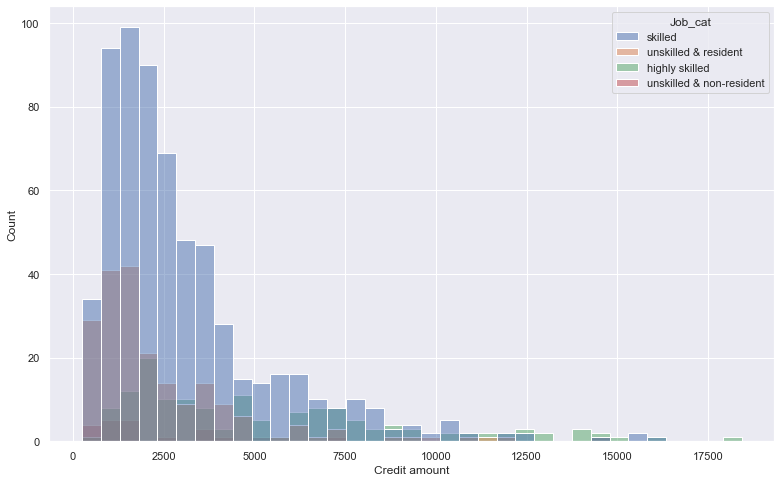

Histogram of  Duration with hue Sex


<AxesSubplot:xlabel='Duration', ylabel='Count'>

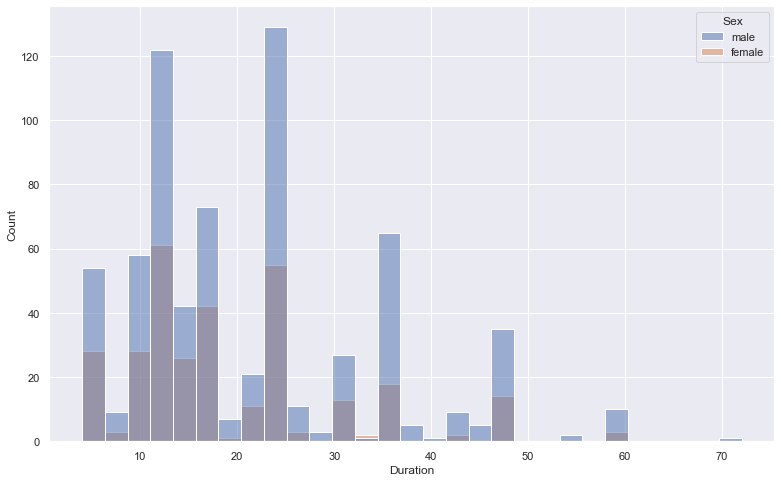

Histogram of  Duration with hue Housing


<AxesSubplot:xlabel='Duration', ylabel='Count'>

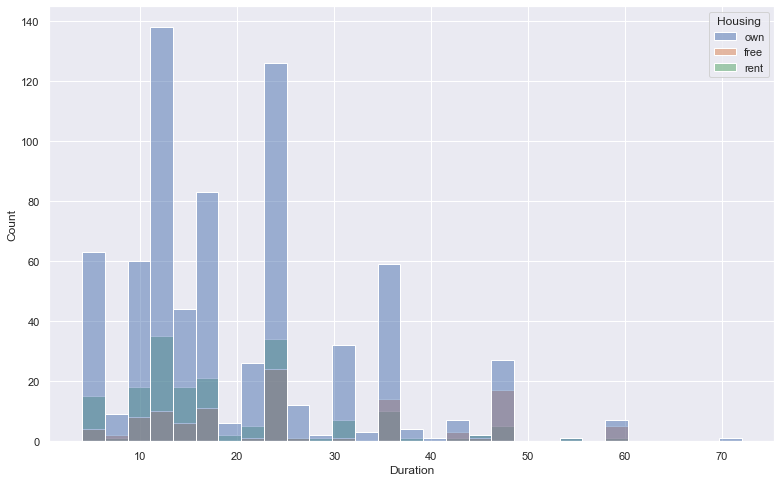

Histogram of  Duration with hue Saving accounts


<AxesSubplot:xlabel='Duration', ylabel='Count'>

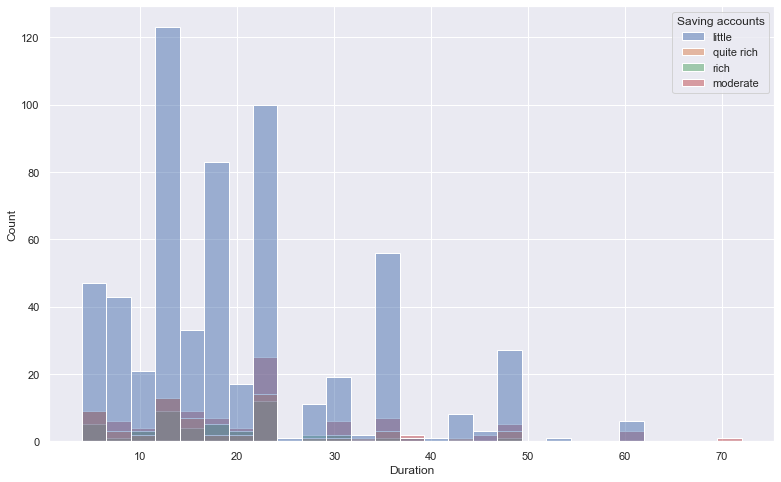

Histogram of  Duration with hue Checking account


<AxesSubplot:xlabel='Duration', ylabel='Count'>

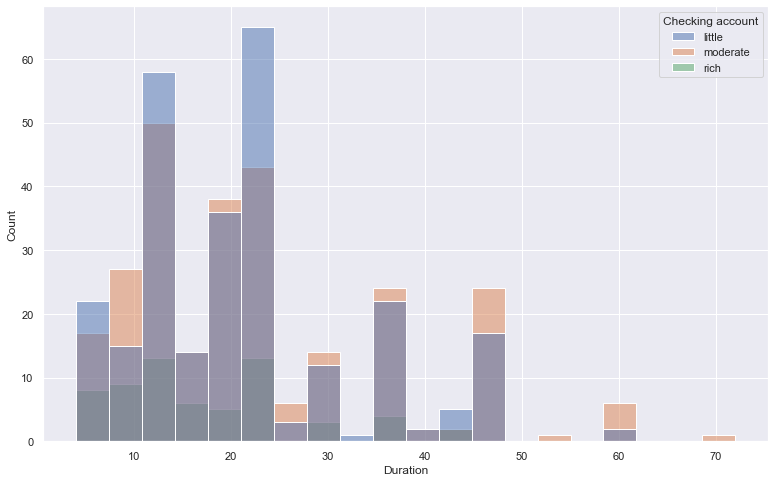

Histogram of  Duration with hue Purpose


<AxesSubplot:xlabel='Duration', ylabel='Count'>

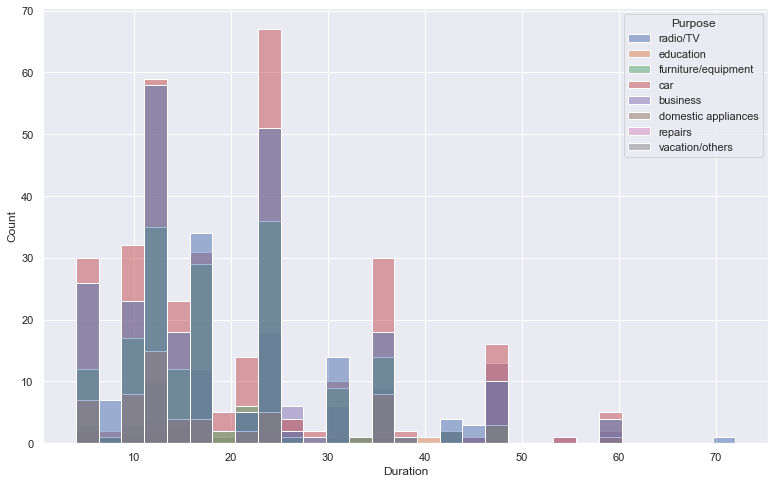

Histogram of  Duration with hue Job_cat


<AxesSubplot:xlabel='Duration', ylabel='Count'>

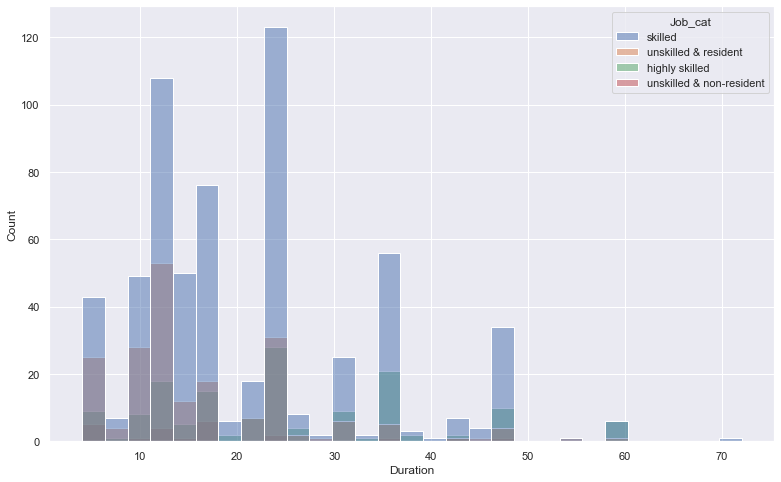

In [430]:
# With hue on sex and categorical variables
for i in df[numericals['index']]:
    for j in df[categories['index']]:
        print("Histogram of ", str(i), "with hue", str(j))
        plt.figure(figsize = (13,8))
        display(sns.histplot(data = df, x = i, hue = j))
        plt.show()

In [86]:
df.columns

Index(['ID', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Job_cat'],
      dtype='object')

### 2. Treating missing values using regression

In [431]:
df.head()

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Job_cat
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,skilled
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,skilled
2,2,49,male,1,own,little,NaN,2096,12,education,unskilled & resident
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,skilled
4,4,53,male,2,free,little,little,4870,24,car,skilled


In [432]:
df['Housing'].unique()

array(['own', 'free', 'rent'], dtype=object)

In [433]:
len(df[df['Saving accounts'].isna() & df['Checking account'].isna()])

99

In [434]:
df2 = df.copy()

In [435]:
df2.drop(columns = ['Job_cat'], inplace = True)

In [436]:
sex = {'male' : 0, 
      'female' : 1}

Housing = {'own' : 0, 
          'free' : 1,
          'rent': 2}

savings = {'little':0, 'quite rich':2, 'rich':3, 'moderate':1}

checking = {'little':0, 'moderate':1, 'rich':2}

purpose = {'radio/TV':0, 'education':1, 'furniture/equipment':2, 'car':3, 'business':4,
       'domestic appliances':5, 'repairs':6, 'vacation/others':7}

df2['Sex'] = df2['Sex'].map(sex)
df2['Housing'] = df2['Housing'].map(Housing)
df2['Saving accounts'] = df2['Saving accounts'].map(savings)
df2['Checking account'] = df2['Checking account'].map(checking)
df2['Purpose'] = df2['Purpose'].map(purpose)

In [437]:
df2.describe()

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,817.000000,606.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,0.310000,1.904000,0.466000,0.456548,0.651815,3271.258000,20.903000,2.096000
std,288.819436,11.375469,0.462725,0.653614,0.779392,0.869350,0.659994,2822.736876,12.058814,1.630166
min,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,250.000000,4.000000,0.000000
25%,249.750000,27.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1365.500000,12.000000,0.000000
50%,499.500000,33.000000,0.000000,2.000000,0.000000,0.000000,1.000000,2319.500000,18.000000,2.000000
75%,749.250000,42.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3972.250000,24.000000,3.000000
max,999.000000,75.000000,1.000000,3.000000,2.000000,3.000000,2.000000,18424.000000,72.000000,7.000000


In [438]:
#Missing value treatment using KNN Imputer
imputer = KNNImputer(n_neighbors=5)
imputed_data = pd.DataFrame(imputer.fit_transform(df2[['Saving accounts', 'Checking account']]))
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float64
 1   1       1000 non-null   float64
dtypes: float64(2)
memory usage: 15.8 KB


In [439]:
imputed_data.head()

,0,1
0,0.0,0.0
1,0.0,1.0
2,0.0,0.2
3,0.0,0.0
4,0.0,0.0


In [440]:
df2['Saving accounts'] = round(imputed_data[0],0)
df2['Checking account'] = round(imputed_data[1],0)

In [441]:
df['Savings'] = df2['Saving accounts']
df['Checking'] = df2['Checking account']

In [491]:
df.fillna(0, inplace = True)

In [492]:
for i, row in df.iterrows():
    if df.loc[i,'Saving accounts'] == 0:
        if row['Savings'] == 0.0:
            df.loc[i,'Saving accounts'] = 'little'
        elif row['Savings'] == 1.0:
            df.loc[i,'Saving accounts'] = 'moderate'
        elif row['Savings'] == 2.0:
            df.loc[i,'Saving accounts'] = 'quite rich'
        else:
            df.loc[i,'Saving accounts'] = 'rich'

In [495]:
for i, row in df.iterrows():
    if df.loc[i,'Checking account'] == 0:
        if row['Checking'] == 0.0:
            df.loc[i,'Checking account'] = 'little'
        elif row['Checking'] == 1.0:
            df.loc[i,'Checking account'] = 'moderate'
        else:
            df.loc[i,'Saving accounts'] = 'rich'

In [500]:
df.drop(columns = ['Savings','Checking'], inplace = True)

In [501]:
df.head()

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Job_cat
0,0,67,male,2,own,little,little,1169,6,radio/TV,skilled
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,skilled
2,2,49,male,1,own,little,little,2096,12,education,unskilled & resident
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,skilled
4,4,53,male,2,free,little,little,4870,24,car,skilled


## Feature Engineering

We do not have a target variable in our case. Hence, we try to scale the data and then apply other techniques over them to analyse further

In [330]:
df2.head()

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,0,2,0,0.0,0.0,1169,6,0
1,1,22,1,2,0,0.0,1.0,5951,48,0
2,2,49,0,1,0,0.0,0.0,2096,12,1
3,3,45,0,2,1,0.0,0.0,7882,42,2
4,4,53,0,2,1,0.0,0.0,4870,24,3


In [331]:
scaler = StandardScaler()

In [332]:
df2_scaled = scaler.fit_transform(df2)

## Clustering the Groups

### K-Means Clustering

In [334]:
inertias = []
silhouette = []
for i in range(1,10):
    kmeans = KMeans(n_clusters = i, random_state = 42)
    kmeans.fit(df2_scaled)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    if i > 1:
        score = silhouette_score(df2_scaled, labels, metric='euclidean')
        silhouette.append(score)

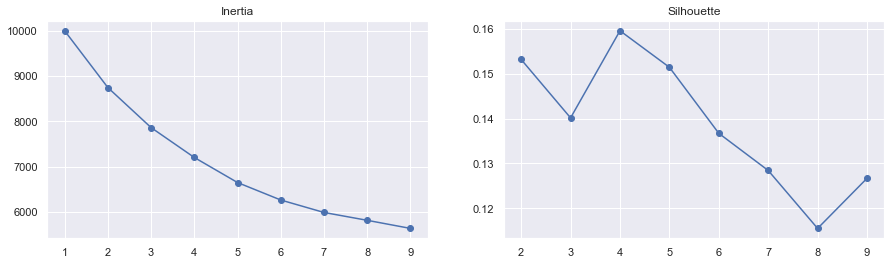

In [335]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 4)
# inertia plot
ax[0].set_title('Inertia')
ax[0].plot(range(1,10), inertias, marker='o')

#silhouette plot
ax[1].set_title('Silhouette')
ax[1].plot(range(2,10), silhouette, marker = 'o')

K-Means is not so clear about the splitting

In [336]:
#Using 2 clsuters
kmeans2 = KMeans(n_clusters = 2, random_state = 42)
kmeans2.fit(df2_scaled)
label2 = kmeans2.labels_
y2 = kmeans2.fit_predict(df2_scaled)

In [337]:
df2['Cluster_2'] = pd.Series(y2)

In [338]:
#Using 4 clsuters
kmeans4 = KMeans(n_clusters = 4, random_state = 42)
kmeans4.fit(df2_scaled)
label4 = kmeans4.labels_
y4 = kmeans4.fit_predict(df2_scaled)

In [339]:
df2['Cluster_4'] = pd.Series(y4)

In [340]:
df2.head()

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Cluster_2,Cluster_4
0,0,67,0,2,0,0.0,0.0,1169,6,0,0,1
1,1,22,1,2,0,0.0,1.0,5951,48,0,1,0
2,2,49,0,1,0,0.0,0.0,2096,12,1,0,1
3,3,45,0,2,1,0.0,0.0,7882,42,2,1,0
4,4,53,0,2,1,0.0,0.0,4870,24,3,1,0


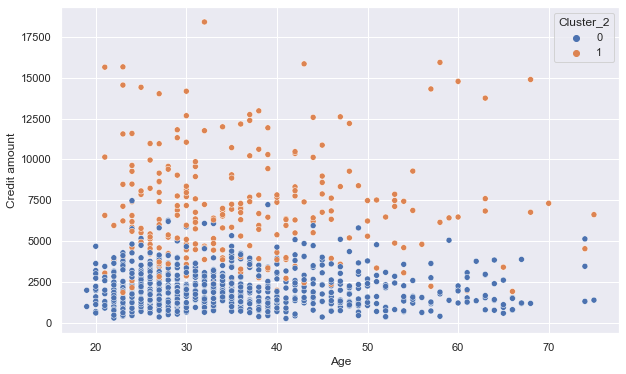

In [341]:
#2 clusters
twoclust = sns.scatterplot(data = df2, y = 'Credit amount', x = 'Age', hue = 'Cluster_2')
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

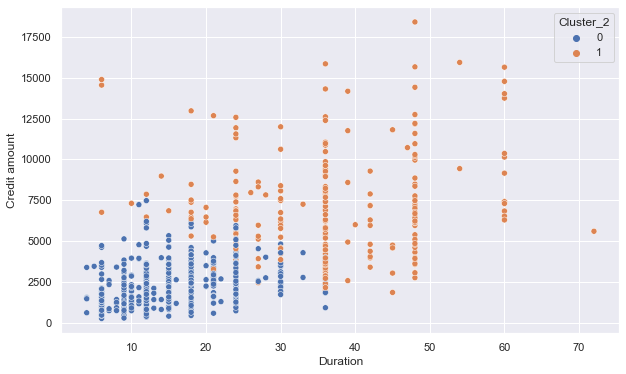

In [342]:
twoclust = sns.scatterplot(data = df2, y = 'Credit amount', x = 'Duration', hue = 'Cluster_2')
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

Using 2 clusters seems to give a clear picture of the distinction

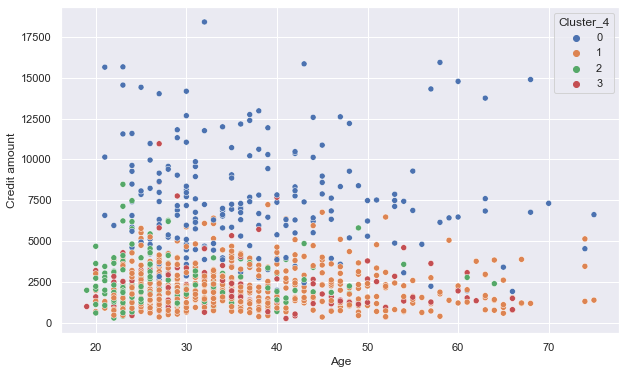

In [343]:
#3 clsuters
sns.scatterplot(data = df2, y = 'Credit amount', x = 'Age', hue = 'Cluster_4' , palette = "deep")
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

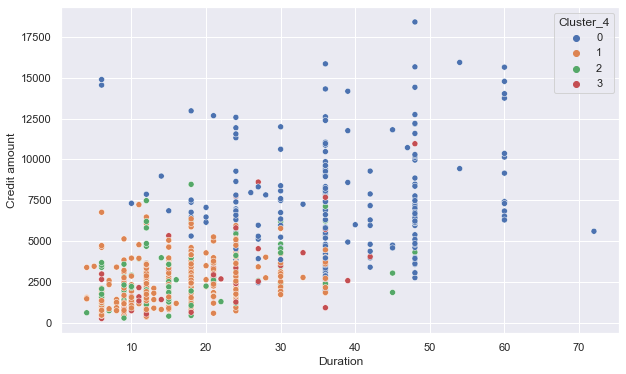

In [344]:
sns.scatterplot(data = df2, y = 'Credit amount', x = 'Duration', hue = 'Cluster_4' , palette = "deep")
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

### Hierarchial Clustering

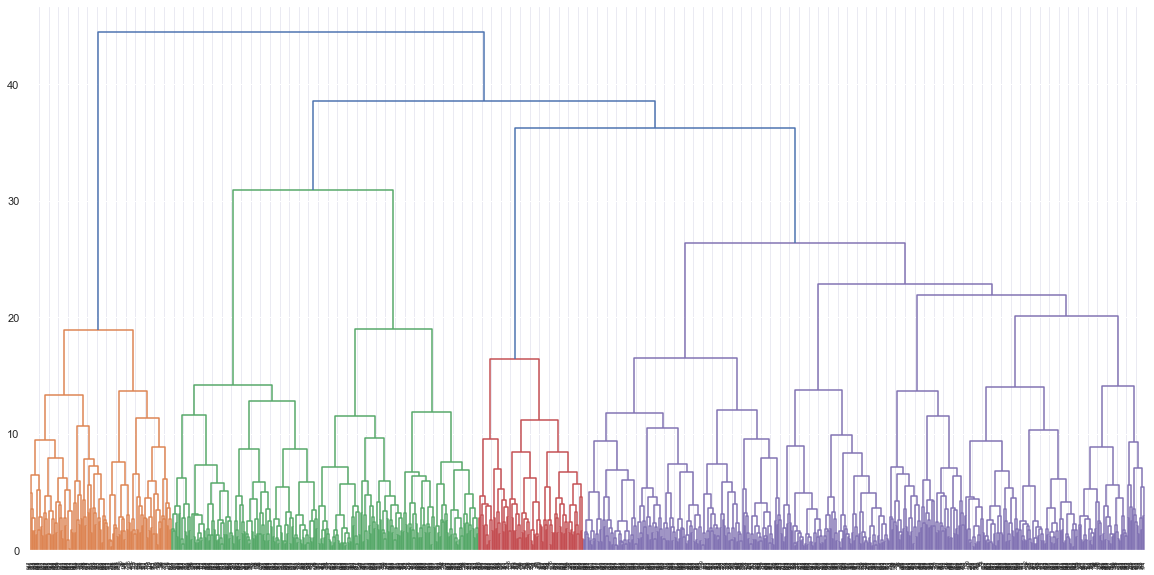

In [345]:
plt.figure(figsize=(20,10))
linkage_ = linkage(df2_scaled, method='ward')
dendrogram_ = dendrogram(linkage_)

The linkage method gives 4 major groups as the categorization

In [356]:
silhouette_agg = []
for i in range(2,11):
    agg = AgglomerativeClustering(n_clusters = i)
    agg.fit(df2_scaled)
    label_agg = agg.labels_
    agg_score = silhouette_score(df2_scaled, label_agg)
    silhouette_agg.append(agg_score)

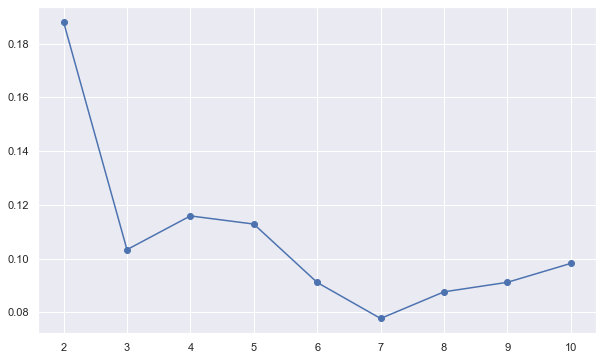

In [357]:
fig.set_size_inches(15, 4)
# Silhouette plot
plt.plot(range(2,11), silhouette_agg, marker='o')

We will go ahead and use 2 and 4 clusters in our case and see how it is representative

In [358]:
#Using 2 clsuters
agg2 = AgglomerativeClustering(n_clusters = 2)
agg2.fit(df2_scaled)
agg_label2 = agg2.labels_
y2 = agg2.fit_predict(df2_scaled)
df2['Agg_Cluster_2'] = pd.Series(y2)

In [359]:
#Using 4 clsuters
agg4 = AgglomerativeClustering(n_clusters = 4)
agg4.fit(df2_scaled)
agg_label4 = agg4.labels_
y4 = agg4.fit_predict(df2_scaled)
df2['Agg_Cluster_4'] = pd.Series(y4)

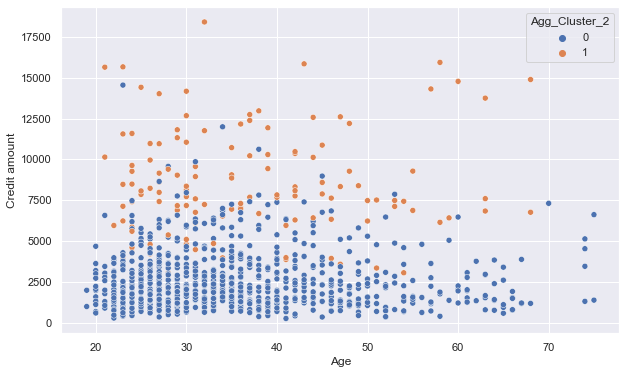

In [360]:
#2 clusters
sns.scatterplot(data = df2, y = 'Credit amount', x = 'Age', hue = 'Agg_Cluster_2')
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

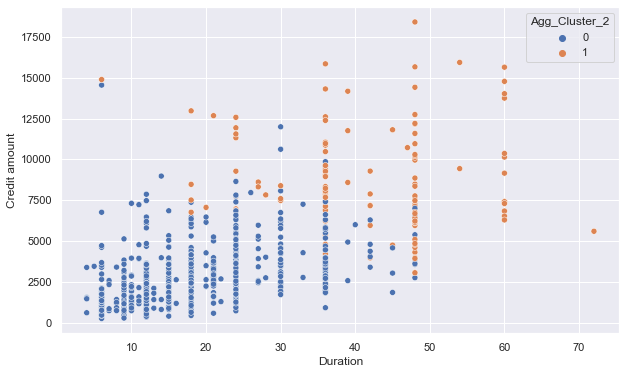

In [361]:
#2 clsuters
sns.scatterplot(data = df2, y = 'Credit amount', x = 'Duration', hue = 'Agg_Cluster_2' , palette = "deep")
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

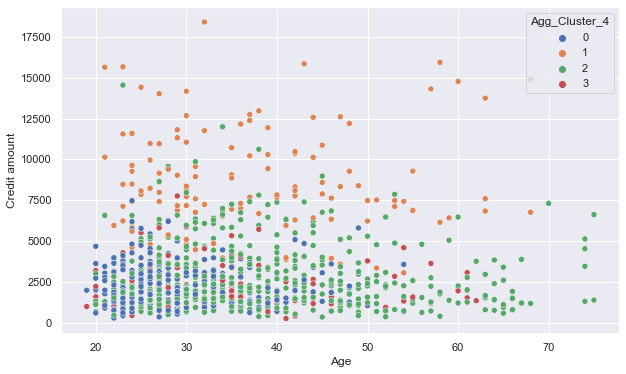

In [362]:
#4 clusters
sns.scatterplot(data = df2, y = 'Credit amount', x = 'Age', hue = 'Agg_Cluster_4', palette = 'deep')
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

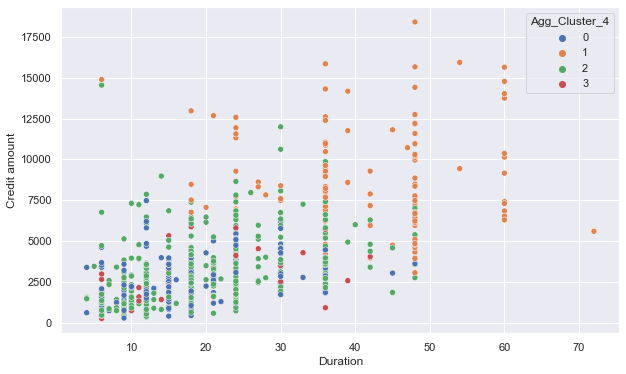

In [363]:
#4 clsuters
sns.scatterplot(data = df2, y = 'Credit amount', x = 'Duration', hue = 'Agg_Cluster_4' , palette = "deep")
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

2 clusters are well differentiated

### DBSCAN Clustering

In [347]:
clusters = []
silhouette = []
eps_range = np.arange(1,2.5,0.05) #selected based on iterations
for i in eps_range:
    dbscan = DBSCAN(eps = i, min_samples = 10, metric = 'euclidean')
    dbscan.fit(df2_scaled)
    db_labels = dbscan.labels_
    uniq_labels = np.unique(db_labels)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        db_score = silhouette_score(df2_scaled, db_labels)
    else:
        db_score = 0
    silhouette.append(db_score)
    clusters.append(n_clusters)
    #clusters.append()
    

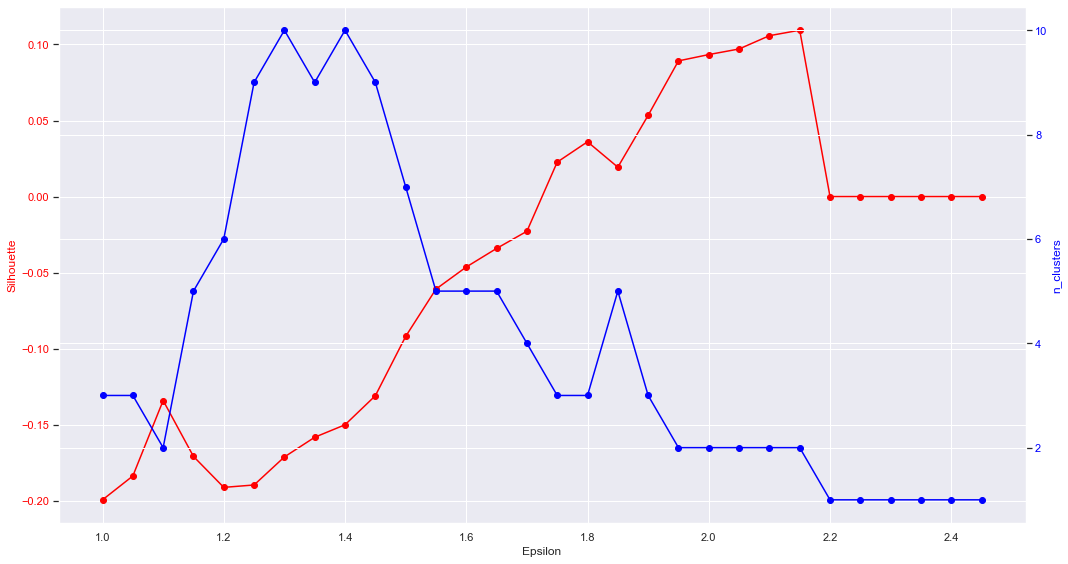

In [348]:
# Silhouette plot - twin axis

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax.plot(eps_range, silhouette, marker='o', color='red')
ax.set_xlabel("Epsilon")
ax.set_ylabel("Silhouette", color = 'red')
ax.tick_params(axis = 'y', labelcolor = 'red')

ax_tw = ax.twinx()
ax_tw.plot(eps_range, clusters, marker='o', color='blue')
ax_tw.set_ylabel('n_clusters', color='blue')
ax_tw.tick_params(axis='y', labelcolor='blue')
fig.tight_layout()

We can choose two value combinations, Epsilon = 1.1 and 1.55

In [349]:
#Epsilon value 2.15
dbscan_2_15 = DBSCAN(eps = 2.15, min_samples = 10, metric = 'euclidean')
dbscan_2_15.fit(df2_scaled)
db_labels_2_15 = dbscan_2_15.labels_
uniq_labels_2_15 = np.unique(db_labels_2_15)
n_clusters_2_15 = len(uniq_labels_2_15[uniq_labels_2_15 != -1])
y2_15 = dbscan_2_15.fit_predict(df2_scaled)
df2['dbscan_eps_2'] = pd.Series(y2_15)

In [350]:
#Epsilon value 1.3
dbscan_1_3 = DBSCAN(eps = 1.95, min_samples = 10, metric = 'euclidean')
dbscan_1_3.fit(df2_scaled)
db_labels_1_3 = dbscan_1_3.labels_
uniq_labels_1_3 = np.unique(db_labels_1_3)
n_clusters_1_3 = len(uniq_labels_1_3[uniq_labels_1_3 != -1])
y1_3 = dbscan_1_3.fit_predict(df2_scaled)
df2['dbscan_eps_1'] = pd.Series(y1_3)

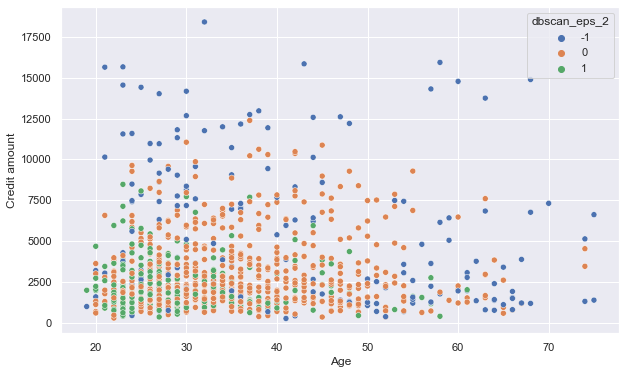

In [351]:
#Epsilon = 2.15
sns.scatterplot(data = df2, y = 'Credit amount', x = 'Age', hue = 'dbscan_eps_2', palette = 'deep')
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

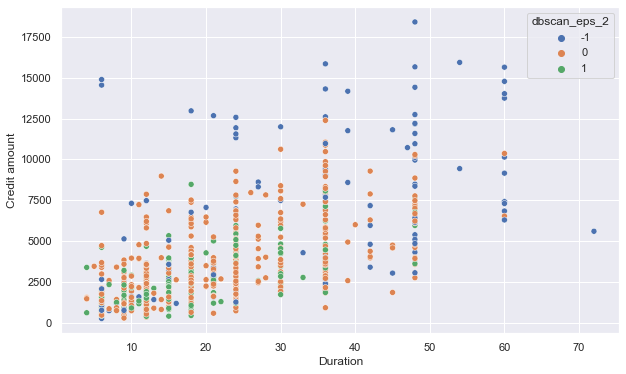

In [352]:
#Epsilon = 2.15
sns.scatterplot(data = df2, y = 'Credit amount', x = 'Duration', hue = 'dbscan_eps_2', palette = 'deep')
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

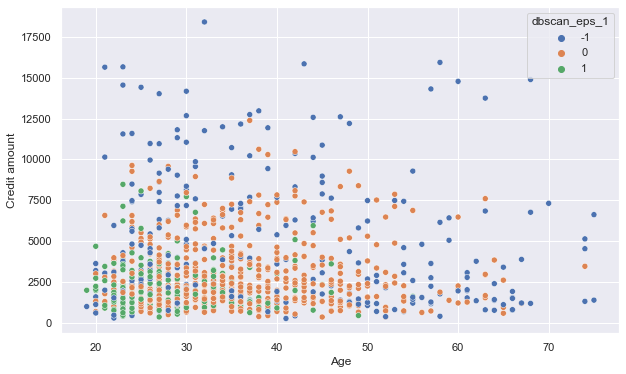

In [353]:
#Epsilon = 1.3
sns.scatterplot(data = df2, y = 'Credit amount', x = 'Age', hue = 'dbscan_eps_1', palette = 'deep')
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

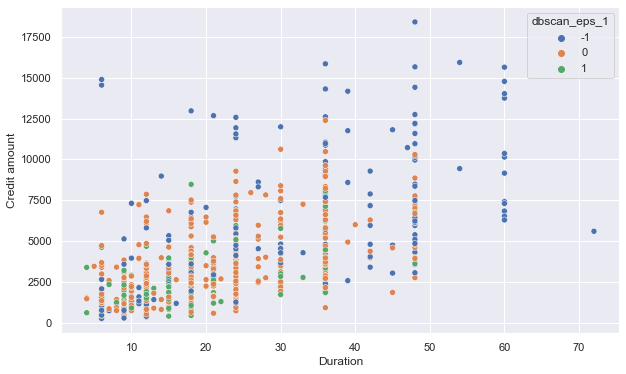

In [354]:
#Epsilon = 1.3
sns.scatterplot(data = df2, y = 'Credit amount', x = 'Duration', hue = 'dbscan_eps_1', palette = 'deep')
sns.set(rc={"figure.figsize":(10, 6)})
plt.show()

## Further Analysis for Recommendations

In [516]:
# Function to print the cluster characteristics

def cluster_characters(x, type, cols):
    
    # Getting the distribution of the clusters
    print('Distribution of the clusters')
    display(df_cluster.groupby(x)[x].count())
    
    print("\n")
    # Getting the distribution of the mean of the cluster
    print('Mean', str(type))
    display(df_cluster.groupby(x)[cols].mean())
    
    print("\n")
    # Getting the distribution of the median of the cluster
    print('Median', str(type))
    display(df_cluster.groupby(x)[cols].median())
    
    print("\n")
    # Plotting categorical variables
    for i in categories['index'].to_list():
        print(str(type), "- categorical output:", str(i),"vs Credit amount")
        plt.figure(figsize = (7,4))
        plt.xlabel(i)
        plt.ylabel(j)
        plt.xticks(rotation = 30)
        display(sns.barplot(data= df_cluster, x = i, y = 'Credit amount', hue=x))
        plt.show()

In [505]:
categories['index'].to_list()

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Job_cat']

### KMeans - Post clustering analysis of clusters

In [378]:
df2.columns

Index(['ID', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Cluster_2',
       'Cluster_4', 'dbscan_eps_2', 'dbscan_eps_1', 'Agg_Cluster_2',
       'Agg_Cluster_4'],
      dtype='object')

In [386]:
df_cluster_cols = df2[['ID', 'Cluster_2','Cluster_4', 'dbscan_eps_2', 'dbscan_eps_1', 'Agg_Cluster_2','Agg_Cluster_4']]

In [384]:
df_cluster = pd.merge(df, df_cluster_cols, how = 'left', on = 'ID')

In [385]:
df_cluster.head()

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Job_cat,Cluster_2,Cluster_4,dbscan_eps_2,dbscan_eps_1,Agg_Cluster_2,Agg_Cluster_4
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,skilled,0,1,0,0,0,2
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,skilled,1,0,1,-1,1,1
2,2,49,male,1,own,little,NaN,2096,12,education,unskilled & resident,0,1,0,0,0,2
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,skilled,1,0,0,-1,1,1
4,4,53,male,2,free,little,little,4870,24,car,skilled,1,0,0,0,0,2


Distribution of the clusters


Cluster_2
0    752
1    248
Name: Cluster_2, dtype: int64



Mean KMeans


,Age,Duration,Credit amount
Cluster_2,,,
0,35.227394,15.968085,2070.658245
1,36.512097,35.866935,6911.786290




Median KMeans


,Age,Duration,Credit amount
Cluster_2,,,
0,33.0,15.0,1819.5
1,34.0,36.0,6463.0




KMeans - categorical output: Sex vs Credit amount


<AxesSubplot:xlabel='Sex', ylabel='Credit amount'>

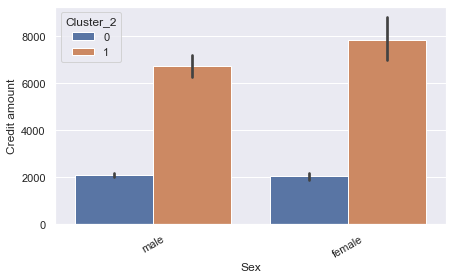

KMeans - categorical output: Housing vs Credit amount


<AxesSubplot:xlabel='Housing', ylabel='Credit amount'>

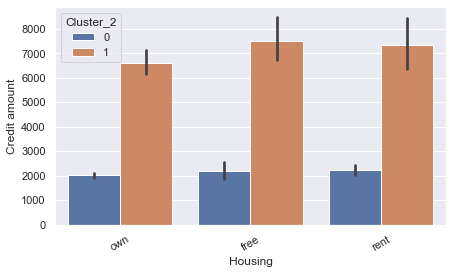

KMeans - categorical output: Saving accounts vs Credit amount


<AxesSubplot:xlabel='Saving accounts', ylabel='Credit amount'>

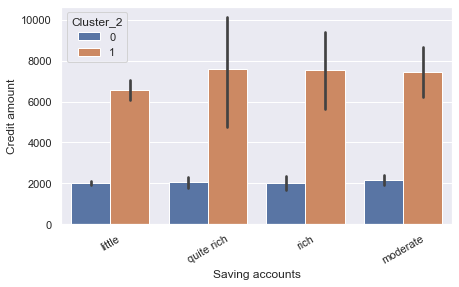

KMeans - categorical output: Checking account vs Credit amount


<AxesSubplot:xlabel='Checking account', ylabel='Credit amount'>

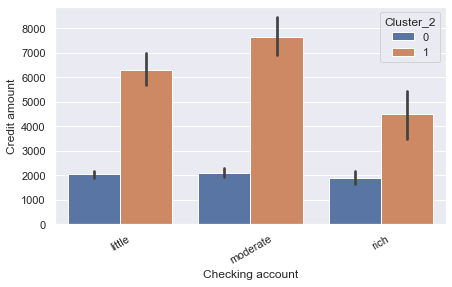

KMeans - categorical output: Purpose vs Credit amount


<AxesSubplot:xlabel='Purpose', ylabel='Credit amount'>

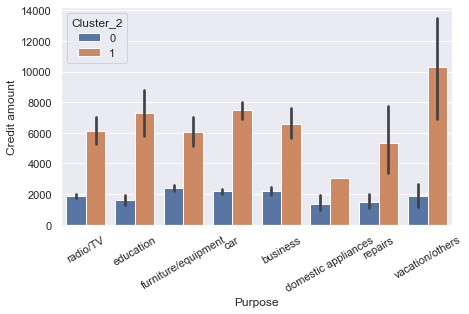

KMeans - categorical output: Job_cat vs Credit amount


<AxesSubplot:xlabel='Job_cat', ylabel='Credit amount'>

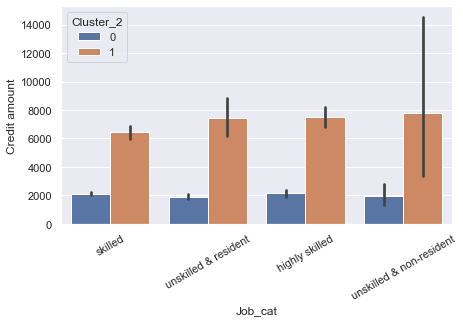

In [517]:
#KMeans - with 2 clusters
cluster_characters('Cluster_2', 'KMeans', ['Age', 'Duration', 'Credit amount'])

Distribution of the clusters


Agg_Cluster_2
0    872
1    128
Name: Agg_Cluster_2, dtype: int64



Mean Hierarchial - 2 values


,Age,Duration,Credit amount
Agg_Cluster_2,,,
0,35.362385,17.951835,2502.657110
1,36.796875,41.007812,8507.351562




Median Hierarchial - 2 values


,Age,Duration,Credit amount
Agg_Cluster_2,,,
0,33.0,18.0,2028.0
1,35.0,42.0,7868.5




Hierarchial - 2 values - categorical output: Sex vs Credit amount


<AxesSubplot:xlabel='Sex', ylabel='Credit amount'>

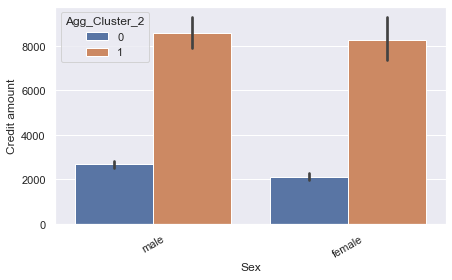

Hierarchial - 2 values - categorical output: Housing vs Credit amount


<AxesSubplot:xlabel='Housing', ylabel='Credit amount'>

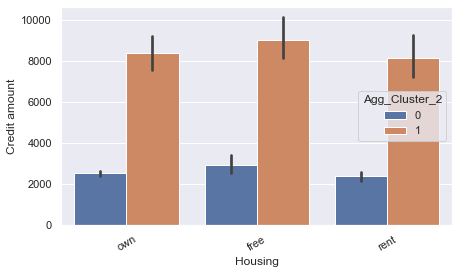

Hierarchial - 2 values - categorical output: Saving accounts vs Credit amount


<AxesSubplot:xlabel='Saving accounts', ylabel='Credit amount'>

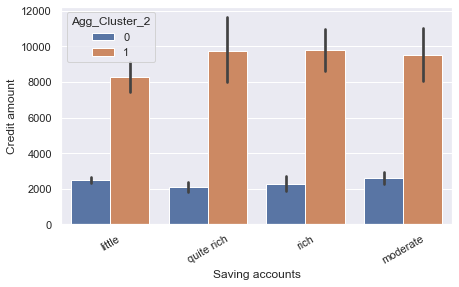

Hierarchial - 2 values - categorical output: Checking account vs Credit amount


<AxesSubplot:xlabel='Checking account', ylabel='Credit amount'>

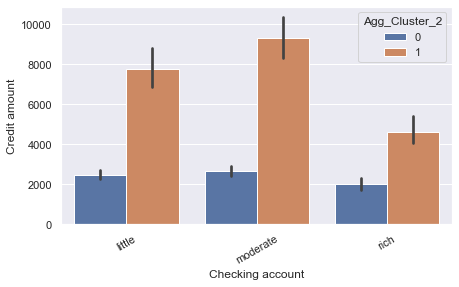

Hierarchial - 2 values - categorical output: Purpose vs Credit amount


<AxesSubplot:xlabel='Purpose', ylabel='Credit amount'>

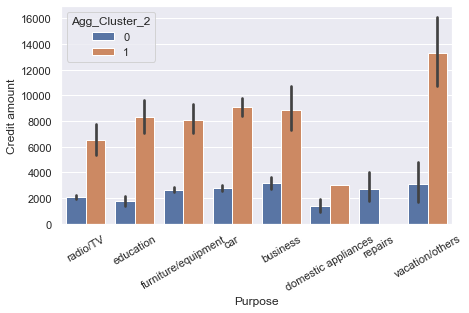

Hierarchial - 2 values - categorical output: Job_cat vs Credit amount


<AxesSubplot:xlabel='Job_cat', ylabel='Credit amount'>

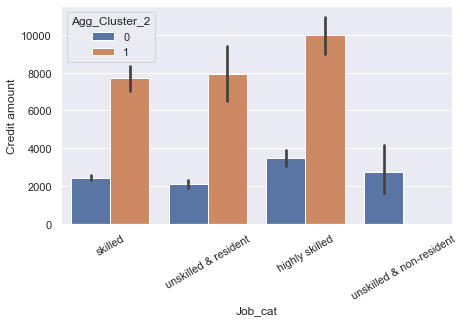

In [518]:
# Hierarchial clusters
cluster_characters('Agg_Cluster_2', 'Hierarchial - 2 values', ['Age', 'Duration', 'Credit amount'])

Distribution of the clusters


dbscan_eps_2
-1    165
 0    603
 1    232
Name: dbscan_eps_2, dtype: int64



Mean DBSCAN - 2 values


,Age,Duration,Credit amount
dbscan_eps_2,,,
-1,42.333333,27.660606,5599.618182
0,35.917081,20.273632,3009.981758
1,29.754310,17.732759,2294.405172




Median DBSCAN - 2 values


,Age,Duration,Credit amount
dbscan_eps_2,,,
-1,40.0,24.0,3868.0
0,34.0,18.0,2333.0
1,27.0,18.0,1843.5




DBSCAN - 2 values - categorical output: Sex vs Credit amount


<AxesSubplot:xlabel='Sex', ylabel='Credit amount'>

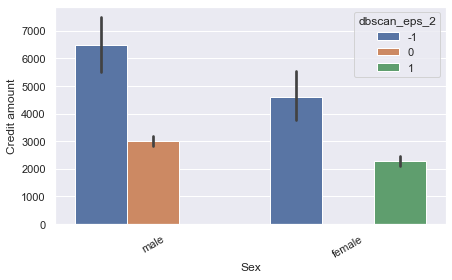

DBSCAN - 2 values - categorical output: Housing vs Credit amount


<AxesSubplot:xlabel='Housing', ylabel='Credit amount'>

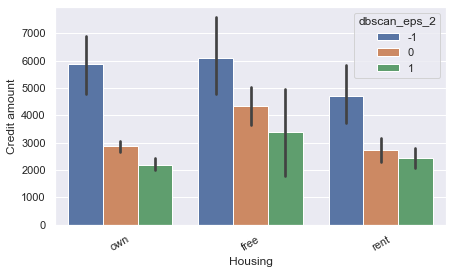

DBSCAN - 2 values - categorical output: Saving accounts vs Credit amount


<AxesSubplot:xlabel='Saving accounts', ylabel='Credit amount'>

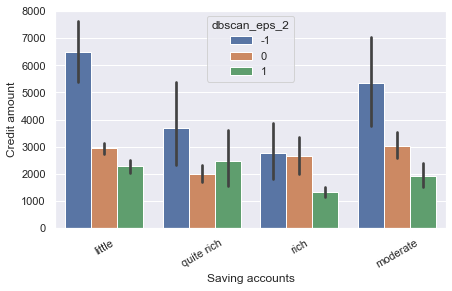

DBSCAN - 2 values - categorical output: Checking account vs Credit amount


<AxesSubplot:xlabel='Checking account', ylabel='Credit amount'>

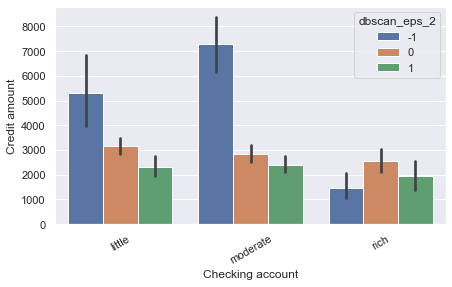

DBSCAN - 2 values - categorical output: Purpose vs Credit amount


<AxesSubplot:xlabel='Purpose', ylabel='Credit amount'>

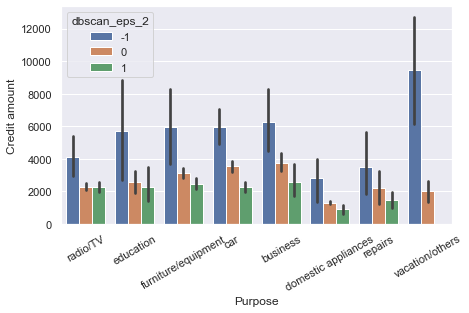

DBSCAN - 2 values - categorical output: Job_cat vs Credit amount


<AxesSubplot:xlabel='Job_cat', ylabel='Credit amount'>

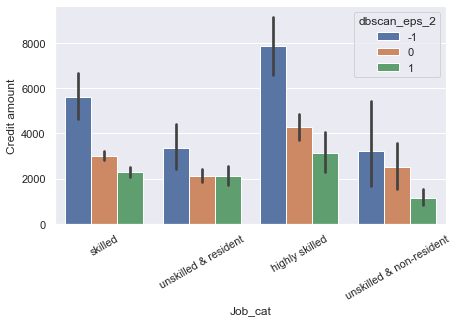

In [519]:
# DBSCAN
cluster_characters('dbscan_eps_2', 'DBSCAN - 2 values', ['Age', 'Duration', 'Credit amount'])

### KMeans:
35.87 seems to be the mean duration and 6911.78 seems to be the mean credit amount of the cluster 1 where we have the riskiest bunch of customers

### Hierarchial:
41.01 seems to be the mean duration and 8507.35 seems to be the mean credit amount of the cluster 1 where we have the riskiest bunch of customers

### DBSCAN:
27.66 seems to be the mean duration and 5599.62 seems to be the mean credit amount of the cluster -1 where we have the riskiest bunch of customers

In none of the cluster groups, there seems to be a role played by the age overall.